<div style="border:solid gray 2px; padding: 30px">
    
* Анализ данных о прокате велосипедов классического типа и с электроприводом:
    * влияния типов билетов и абонементов на предпотения по выбору типа велосипеда;
    * станции на которых чаще всего оставляют велосипеды в конце проката;
    * востребованность арендных велосипедов по типам;
    * самые популярные маршруты "туда-обратно", с отправлением и завршением аренды с одной станции;
    * длительность аренды в зависимости от типа велосипеда;
    * среднее время аренды велосипедов.

#### **1. Загрузка исходных данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

df = pd.read_csv("datasets\\rent_bike.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119849 entries, 0 to 119848
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              119849 non-null  int64  
 1   duration             119849 non-null  int64  
 2   start_time           119849 non-null  object 
 3   end_time             119849 non-null  object 
 4   start_station        119849 non-null  int64  
 5   start_lat            119840 non-null  float64
 6   start_lon            119840 non-null  float64
 7   end_station          119849 non-null  int64  
 8   end_lat              117663 non-null  float64
 9   end_lon              117663 non-null  float64
 10  bike_id              119849 non-null  int64  
 11  plan_duration        119849 non-null  int64  
 12  trip_route_category  119849 non-null  object 
 13  passholder_type      119849 non-null  object 
 14  bike_type            119849 non-null  object 
dtypes: float64(4), in

In [3]:
df.head(3)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,341828178,87,1/1/2024 0:10,1/1/2024 1:37,4515,34.039742,-118.442268,4564,34.035351,-118.434143,24169,30,One Way,Monthly Pass,electric
1,341816845,6,1/1/2024 0:12,1/1/2024 0:18,4602,34.164951,-118.363632,4603,34.152142,-118.361954,15430,1,One Way,Walk-up,standard
2,341817147,20,1/1/2024 0:15,1/1/2024 0:35,3064,34.046131,-118.257591,3081,34.031891,-118.250183,5913,30,One Way,Monthly Pass,standard


#### **2. Предобработка**

* выбор необходимы столбцов для дальнейших расчетов

In [4]:
data = df.iloc[:, [0,1,2,3,4,7,10,11,12,13,14]]
data.head()

,trip_id,duration,start_time,end_time,start_station,end_station,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,341828178,87,1/1/2024 0:10,1/1/2024 1:37,4515,4564,24169,30,One Way,Monthly Pass,electric
1,341816845,6,1/1/2024 0:12,1/1/2024 0:18,4602,4603,15430,1,One Way,Walk-up,standard
2,341817147,20,1/1/2024 0:15,1/1/2024 0:35,3064,3081,5913,30,One Way,Monthly Pass,standard
3,341817198,16,1/1/2024 0:22,1/1/2024 0:38,4543,4583,6132,1,One Way,Walk-up,standard
4,341816990,5,1/1/2024 0:23,1/1/2024 0:28,4518,4587,29601,365,One Way,Annual Pass,electric


* нулевые знаечния в исходных данных

In [5]:
data.isna().sum()

trip_id                0
duration               0
start_time             0
end_time               0
start_station          0
end_station            0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
bike_type              0
dtype: int64

* замена типа данных на формат времени

In [6]:
data.loc[:,'start_time'] = pd.to_datetime(data.loc[:,'start_time'], format='%m/%d/%Y %H:%M')
data.loc[:,'end_time'] = pd.to_datetime(data.loc[:,'end_time'], format='%m/%d/%Y %H:%M')
data.head()

,trip_id,duration,start_time,end_time,start_station,end_station,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,341828178,87,2024-01-01 00:10:00,2024-01-01 01:37:00,4515,4564,24169,30,One Way,Monthly Pass,electric
1,341816845,6,2024-01-01 00:12:00,2024-01-01 00:18:00,4602,4603,15430,1,One Way,Walk-up,standard
2,341817147,20,2024-01-01 00:15:00,2024-01-01 00:35:00,3064,3081,5913,30,One Way,Monthly Pass,standard
3,341817198,16,2024-01-01 00:22:00,2024-01-01 00:38:00,4543,4583,6132,1,One Way,Walk-up,standard
4,341816990,5,2024-01-01 00:23:00,2024-01-01 00:28:00,4518,4587,29601,365,One Way,Annual Pass,electric


* уникальные значения количества дней в зависимост категории от билета

In [7]:
data['plan_duration'].unique()

array([ 30,   1, 365], dtype=int64)

* основные показатели по времени аренды

In [8]:
data['duration'].describe()

count    119849.000000
mean         28.778396
std          86.260451
min           1.000000
25%           7.000000
50%          14.000000
75%          26.000000
max        1440.000000
Name: duration, dtype: float64

* разбивка даты на месяцы с функцией учета года

In [9]:
data.loc[:,'month'] = data.loc[:,'start_time'].values.astype('datetime64[M]')
data.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_4132\2158487250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'month'] = data.loc[:,'start_time'].values.astype('datetime64[M]')


,trip_id,duration,start_time,end_time,start_station,end_station,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,month
0,341828178,87,2024-01-01 00:10:00,2024-01-01 01:37:00,4515,4564,24169,30,One Way,Monthly Pass,electric,2024-01-01
1,341816845,6,2024-01-01 00:12:00,2024-01-01 00:18:00,4602,4603,15430,1,One Way,Walk-up,standard,2024-01-01


#### **3. Исследовательский анализ**

#### **3.1. Длительность аренды по типам билетов**

* диаграмма размаха для различных типов билетов

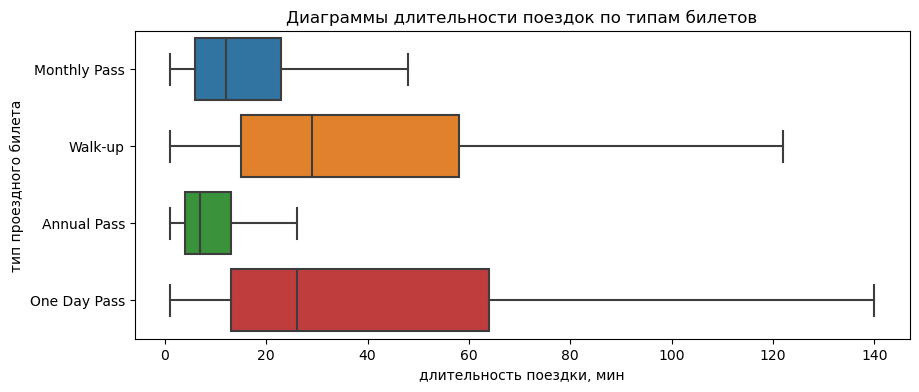

In [10]:
plt.figure(figsize = (10,4))
sns.boxplot(data=data, x='duration', y='passholder_type', showfliers=False)
plt.xlabel('длительность поездки, мин')
plt.ylabel('тип проездного билета')
plt.title('Диаграммы длительности поездок по типам билетов')
plt.show()

* расчет количества аренд с длительностью более 150минут - ограничение выборки до 150 минут

In [11]:
np.percentile(data['duration'], [90, 95, 98])

array([ 50.,  83., 150.])

In [12]:
len(data[(data['duration']<=1440) & (data['duration']>150)])

2372

* группа по длительности аренды - до 150мин (более 98% всех клиентов)

In [13]:
df_less = data[data['duration']<150]

* группа по длительности аренды - более 140мин (оставшаяся часть клиентов, менее 2%)

In [14]:
df_more = data[data['duration']>=150]

* график распределения для группы с арендой не более 150 мин 

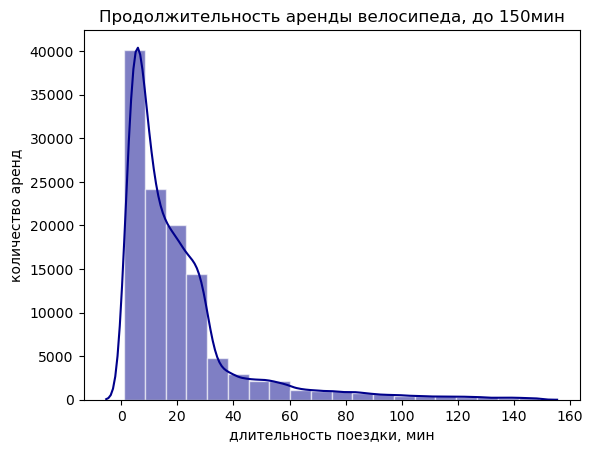

In [15]:
sns.histplot(df_less['duration'], alpha=.5, edgecolor=(1, 1, 1, .6), 
             kde=True, bins=20, color = 'darkblue', kde_kws=dict(cut=3))
plt.xlabel('длительность поездки, мин')
plt.ylabel('количество аренд')
plt.title('Продолжительность аренды велосипеда, до 150мин')
plt.show()

#### **3.2. Длительность аренды по типу велосипеда**

* диаграмма размаха для различных типов велосипедов с арендой до 150 минут

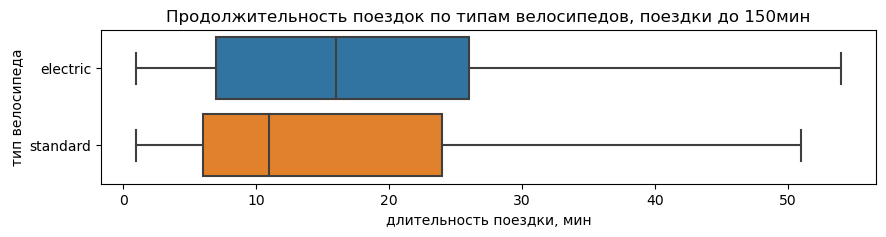

In [16]:
plt.figure(figsize = (10,2))
sns.boxplot(data=df_less, x='duration', y='bike_type', showfliers=False)
plt.xlabel('длительность поездки, мин')
plt.ylabel('тип велосипеда')
plt.title('Продолжительность поездок по типам велосипедов, поездки до 150мин')
plt.show()

* диаграмма размаха для различных типов велосипедов с арендой более 140 минут

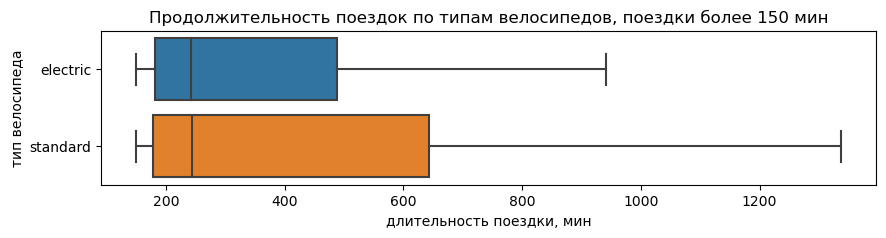

In [17]:
plt.figure(figsize = (10,2))
sns.boxplot(data=df_more, x='duration', y='bike_type', showfliers=False)
plt.xlabel('длительность поездки, мин')
plt.ylabel('тип велосипеда')
plt.title('Продолжительность поездок по типам велосипедов, поездки более 150 мин')
plt.show()

#### **3.3. Востребованность по типам велосипеда**

* количество аренд по типам велосипеда и медианное значение времени аренды

In [18]:
df_trip_count = data.groupby('bike_type').agg({'trip_id':'count', 'duration':'median'}).reset_index()
df_trip_count

,bike_type,trip_id,duration
0,electric,70481,16.0
1,standard,49368,11.0


* номера id велосипедов с повышенным износом - по количеству поездок 

In [19]:
df_bike_type = data.groupby('bike_id').agg({'trip_id':'count', 'bike_type':'first'}).sort_values(by='trip_id',
                                                                                  ascending=False).reset_index()
df_bike_type.head(5)

,bike_id,trip_id,bike_type
0,16875,443,electric
1,28380,434,electric
2,26866,433,electric
3,29206,420,electric
4,23438,393,electric


* количество велосипедов в аренде по типам и медианное значение количества поездок на каждый тип

In [20]:
df_bike_type = df_bike_type.groupby('bike_type').agg({'bike_id':'count', 'trip_id':'mean'}).reset_index()
df_bike_type

,bike_type,bike_id,trip_id
0,electric,327,215.538226
1,standard,1532,32.224543


* объединение таблиц и переименование столбцов

In [21]:
df_bike_type = df_bike_type.merge(df_trip_count, on='bike_type', how='left')
df_bike_type = df_bike_type.rename(columns = {'bike_id':'amount_bike',
                                                  'trip_id_x':'mean_trip', 'trip_id_y':'count_trip'})
df_bike_type

,bike_type,amount_bike,mean_trip,count_trip,duration
0,electric,327,215.538226,70481,16.0
1,standard,1532,32.224543,49368,11.0


* переименование индекса

In [22]:
df_bike_type = df_bike_type.set_index('bike_type')

* процент поездок приходящихся на каждый тип велосипеда, с учетом количества имеющихся велосипедов в арендном парке

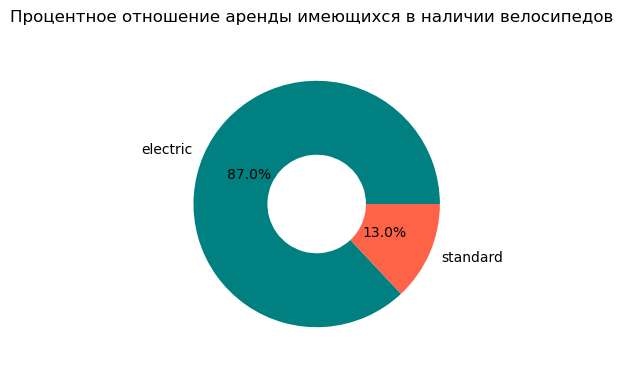

In [23]:
df_bike_type.iloc[:, 1].plot.pie(figsize=(4, 4), autopct='%1.1f%%', wedgeprops=dict(width=0.6), ylabel='',
                                     title="Процентное отношение аренды имеющихся в наличии велосипедов",
                                     colors=['teal', 'tomato'], subplots=True)
plt.show()

#### **3.4. Востребованность велосипедов по типам билетов**

* востребованность типа велосипедов в зависимости от типа билетов

In [24]:
df_ticket_type = data.pivot_table(index = ['passholder_type'], columns='bike_type', values='trip_id', aggfunc=['count'])
df_ticket_type

count         
bike_type       electric standard
passholder_type                  
Annual Pass         6113     5979
Monthly Pass       54243    26289
One Day Pass        3099     5044
Walk-up             7026    12056

* удаление первого уровеня наименований колонок

In [25]:
df_ticket_type.columns = df_ticket_type.columns.droplevel(0)
df_ticket_type

bike_type,electric,standard
passholder_type,,
Annual Pass,6113,5979
Monthly Pass,54243,26289
One Day Pass,3099,5044
Walk-up,7026,12056


* диаграмма спроса на велосипед по типам билетов

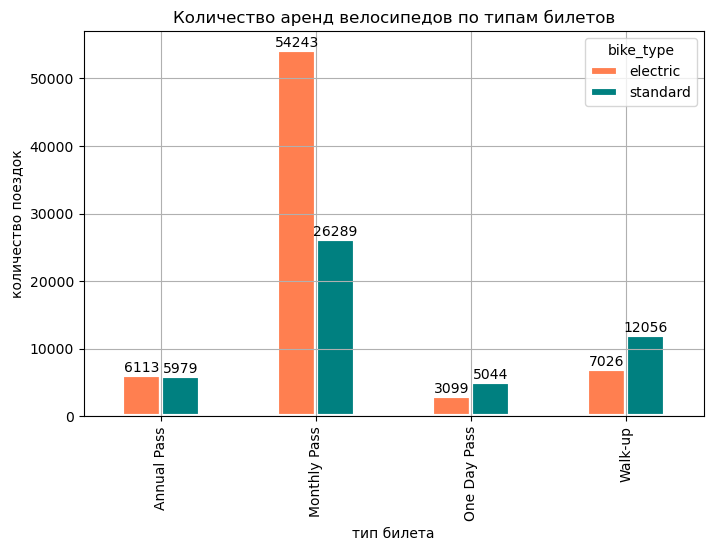

In [26]:
ax = df_ticket_type.plot(kind='bar',figsize=(8,5), grid=True, color=['coral', 'teal'], edgecolor='white', linewidth=3)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlabel('тип билета')  
ax.set_ylabel('количество поездок')
plt.title('Количество аренд велосипедов по типам билетов')
plt.show()

* спрос по типу велосипеда

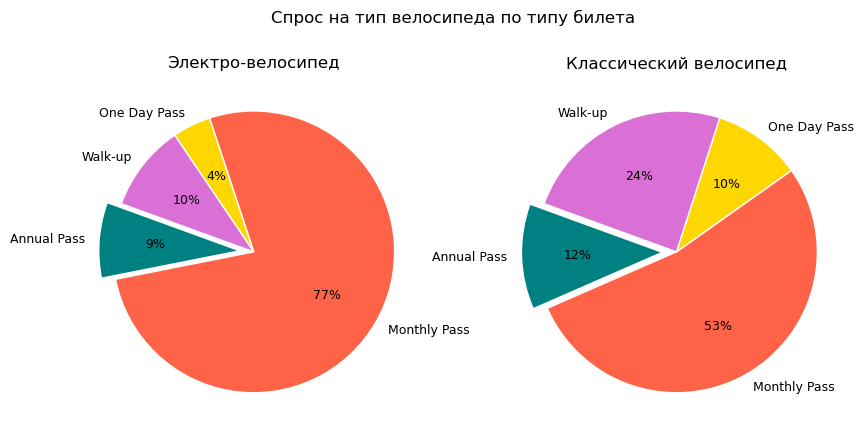

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Спрос на тип велосипеда по типу билета')

labels=['Annual Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up']
colours = {'Annual Pass':'teal', 'Monthly Pass':'tomato', 'One Day Pass':'gold', 'Walk-up':'orchid'}
           
df_ticket_type.loc[:,'electric'].plot.pie(ax=ax1, autopct='%1.0f%%', explode=[0.1, 0, 0, 0], ylabel='', 
                     legend=False,labeldistance=1.1, wedgeprops={'lw':1, 'ls':'-','edgecolor':"white"},
                     subplots=True, textprops={'fontsize':9}, colors=[colours[key] for key in labels],
                     startangle=160)
ax1.set_title('Электро-велосипед')

df_ticket_type.loc[:,'standard'].plot.pie(ax=ax2, autopct='%1.0f%%', explode=[0.1, 0, 0, 0], ylabel='', 
                     legend=False,labeldistance=1.1, wedgeprops={'lw':1, 'ls':'-','edgecolor':"white"},
                     subplots=True, textprops={'fontsize':9}, colors=[colours[key] for key in labels],
                     startangle=160)
ax2.set_title('Классический велосипед')
plt.show()

#### **3.5. Станция с наибольшим и наименьшим количеством стартов**

* подсчет количества аренд по месяцам (равномерность спроса аренды)

In [28]:
data.set_index('start_time').groupby(pd.Grouper(freq='M'))['duration'].count().to_frame()

,duration
start_time,
2024-01-31,40520
2024-02-29,36065
2024-03-31,43264


In [29]:
df_start_station = data.pivot_table(index='start_station', columns='month',
                                    values='trip_id', aggfunc='count').sort_values(by='2024-01-01', ascending=False)
df_start_station.head(10)

month,2024-01-01,2024-02-01,2024-03-01
start_station,,,
4214,1442.0,1176.0,1735.0
3005,1356.0,911.0,945.0
3035,1096.0,950.0,818.0
4215,1047.0,898.0,1332.0
3006,882.0,811.0,1214.0
4210,768.0,692.0,1027.0
3063,764.0,794.0,507.0
4613,634.0,497.0,534.0
3064,617.0,462.0,490.0


* удаление первого уровеня наименований колонок и переименование столбцов

In [30]:
df_start_station.columns = ['январь', 'февраль', 'март']
df_start_station

,январь,февраль,март
start_station,,,
4214,1442.0,1176.0,1735.0
3005,1356.0,911.0,945.0
3035,1096.0,950.0,818.0
4215,1047.0,898.0,1332.0
3006,882.0,811.0,1214.0
...,...,...,...
4600,7.0,29.0,36.0
3000,4.0,1.0,4.0
4539,2.0,NaN,NaN


* таблицы с минимальным и максимальным спросом велосипедов по станциям

In [31]:
df_start_max = df_start_station[:5].sort_values(by='январь',ascending=True)
df_start_min = df_start_station[-6:-1].sort_values(by='январь',ascending=True)

* диаграмма спроса на велосипед на самых популярных станциях

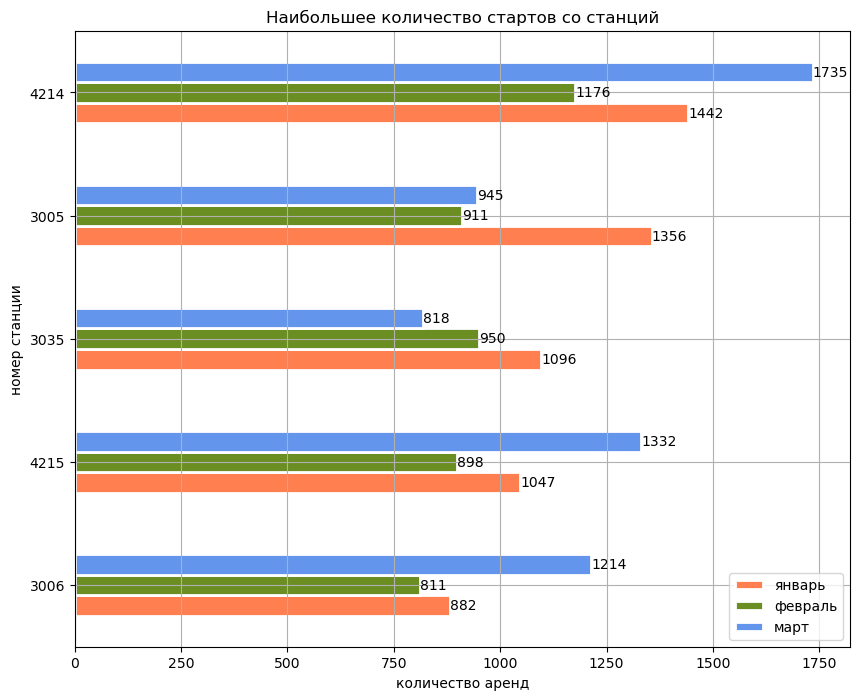

In [32]:
ax = df_start_max.plot(kind='barh',figsize=(10,8), grid=True,
                       color=['coral', 'olivedrab', 'cornflowerblue'],
                       edgecolor='white', linewidth=2)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlabel('количество аренд')  
ax.set_ylabel('номер станции')
plt.title('Наибольшее количество стартов со станций')
plt.show()

* диаграмма спроса на велосипед на станциях с малым спросом

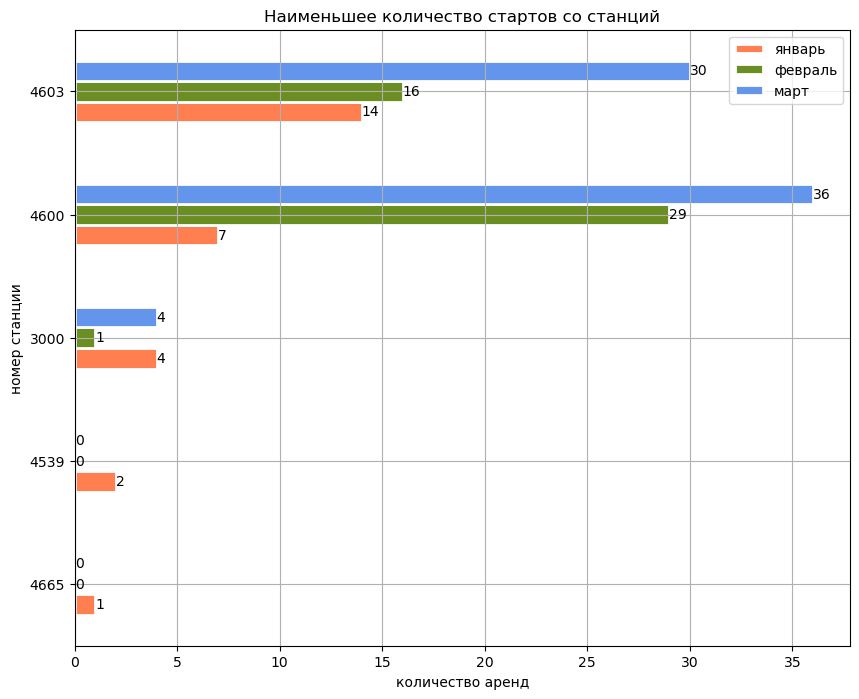

In [33]:
ax = df_start_min.plot(kind='barh',figsize=(10,8), grid=True,
                       color=['coral', 'olivedrab', 'cornflowerblue'],
                       edgecolor='white', linewidth=2)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlabel('количество аренд')  
ax.set_ylabel('номер станции')
plt.title('Наименьшее количество стартов со станций')
plt.show()

#### **3.6. Станция где берут аренду на день с маршрутом "туда-обратно"**

* таблица с маршрутами "туда-обратно"

In [34]:
df_roundtrip = data[data['trip_route_category']=='Round Trip']
df_roundtrip.head(6)

,trip_id,duration,start_time,end_time,start_station,end_station,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,month
41,341828749,25,2024-01-01 01:33:00,2024-01-01 01:58:00,3077,3077,24238,30,Round Trip,Monthly Pass,electric,2024-01-01
59,341838637,15,2024-01-01 02:18:00,2024-01-01 02:33:00,4491,4491,13872,1,Round Trip,Walk-up,standard,2024-01-01
60,341838260,1,2024-01-01 02:23:00,2024-01-01 02:24:00,4454,4454,15557,1,Round Trip,One Day Pass,standard,2024-01-01
77,341849201,1,2024-01-01 03:30:00,2024-01-01 03:31:00,4582,4582,15432,30,Round Trip,Monthly Pass,standard,2024-01-01
78,341849435,11,2024-01-01 03:31:00,2024-01-01 03:42:00,4582,4582,15432,30,Round Trip,Monthly Pass,standard,2024-01-01
85,341877797,16,2024-01-01 06:37:00,2024-01-01 06:53:00,4491,4491,5815,30,Round Trip,Monthly Pass,standard,2024-01-01


* наиболее востребованные 6 станции с маршрутами "туда-обратно"

In [35]:
df_roundtrip = df_roundtrip.pivot_table(index='start_station', values='duration',
                         aggfunc='count').sort_values(by='duration', ascending=False)[:6]
df_roundtrip

,duration
start_station,
4214,1613
4558,1216
4215,816
3006,802
4210,739
3035,676


* диаграмма спроса на велосипед на самых популярных станциях туда-обратно

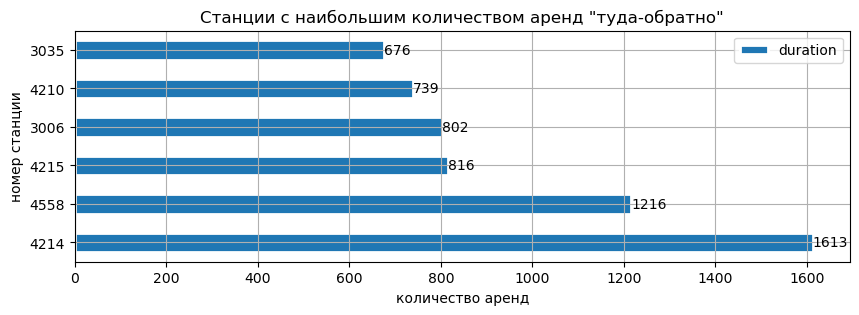

In [36]:
ax = df_roundtrip.plot(kind='barh',figsize=(10,3), grid=True,
                       edgecolor='white', linewidth=2)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlabel('количество аренд')  
ax.set_ylabel('номер станции')
plt.title('Станции с наибольшим количеством аренд "туда-обратно"')
plt.show()

#### **3.7. Какой тип велосипедов чаще берут в аренду на период от 10 до 24 часов**

* процент от общего числа аренд

In [37]:
len(data[data['duration']>=600])/len(data['duration'])*100

0.46558586220994747

* тип велосипедов по количеству аренд от 10 часов

In [38]:
df_rent_day = data[data['duration']>=600]
df_rent_day.groupby('bike_type')['duration'].count().to_frame()

,duration
bike_type,
electric,258
standard,300


#### **3.8. Станции на которых чаще всего оставляют велосипеды после аренды**

* станции где чаще всего отавляют велосипеды в конце проката (для сервиса)

In [39]:
df_end_day = data.pivot_table(index='end_station', columns='bike_type', values='trip_id',
                         aggfunc='count').sort_values(by='electric', ascending=False)[:15]
df_end_day

bike_type,electric,standard
end_station,,
3006,2405.0,492.0
3005,2353.0,927.0
3035,2091.0,801.0
4558,1849.0,236.0
4215,1726.0,2348.0
3063,1725.0,319.0
4214,1372.0,2440.0
3000,1265.0,921.0
3031,1004.0,546.0


* диаграмма по станциям и типом велосипедов, на которых чаще всего оставляют велосипеды в конце проката

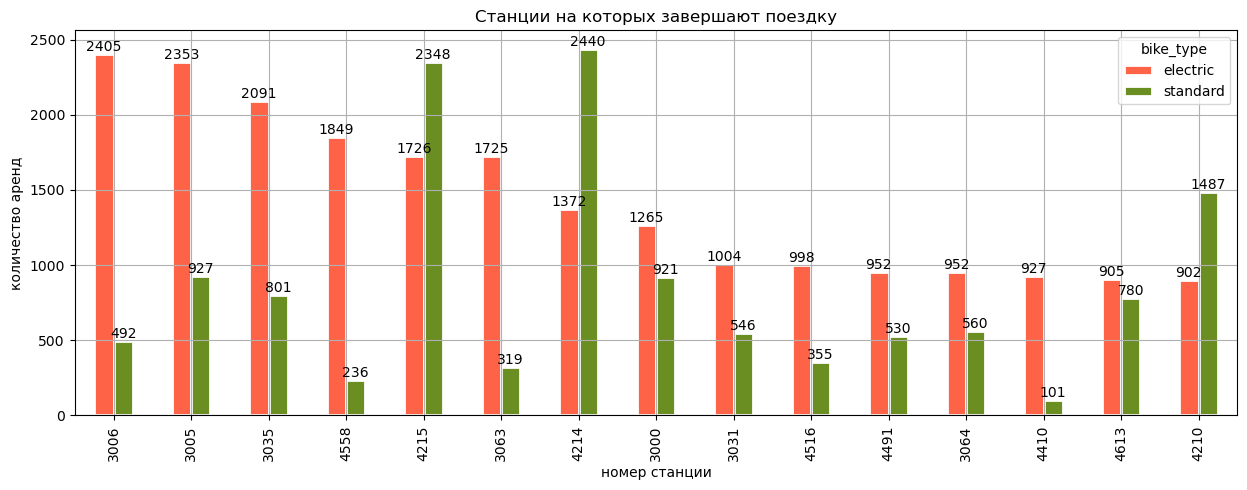

In [40]:
ax = df_end_day.plot(kind='bar',figsize=(15,5), grid=True,
                       color=['tomato', 'olivedrab'],
                       edgecolor='white', linewidth=2)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_xlabel('номер станции')  
ax.set_ylabel('количество аренд')
plt.title('Cтанции на которых завершают поездку')
plt.show()

#### **4. Проверка гипотез**

#### **4.1. Время аренды классического и электро велосипедов**

* **гипотеза Н0 - средние время аренды электро и классического велосипедов одинаковое**
* **гипотеза Н1 - средние время аренды электро велосипедов больше чем классического**

* сравнение для значений арендного времени менее 150 минут

In [41]:
df_electric = df_less[df_less['bike_type']=='electric']
df_standard = df_less[df_less['bike_type']=='standard']

* распределение аренды по времени, по типам велосипедов 

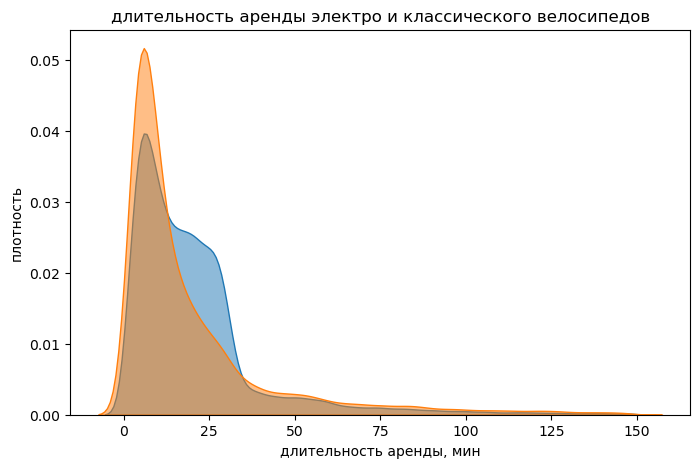

In [42]:
plt.figure(figsize = (8,5))
sns.kdeplot(df_electric['duration'], fill=True, alpha=0.5, linewidth=1.0)
sns.kdeplot(df_standard['duration'], fill=True, alpha=0.5, linewidth=1.0)
plt.xlabel('длительность аренды, мин')
plt.ylabel('плотность')
plt.title('длительность аренды электро и классического велосипедов')
plt.show()

* проверка гипотезы

In [43]:
alpha = 0.05

results = st.ttest_ind(df_electric['duration'], df_standard['duration'], alternative='greater')

print('медиана аренды электро велосипеда:', df_electric['duration'].median())
print('медиана аренды классического велосипеда:', df_standard['duration'].median())
print()
print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

медиана аренды электро велосипеда: 16.0
медиана аренды классического велосипеда: 11.0

p-значение: 1.6164193015294177e-05
Отвергаем нулевую гипотезу
